In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

In [2]:
import os
import sys

ruta =os.getcwd()
sys.path.append(ruta)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Leer el archivo CSV
df_nuevos = pd.read_csv("data/datos_nuevos_creditos_analisis.csv")
df_historico = pd.read_csv("data/datos_historicos_clasificados.csv")

In [5]:
df_nuevos.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NewLoanApplication,RiesgoPagAtrazo,probNoPago,Segment,int_rc_Segment,int_rc
0,10001,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20,37752.0,Riesgo medio,0.170585,Riesgo bajo,0.03,0.18
1,10002,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21,52917.0,Riesgo alto,0.110997,Riesgo bajo,0.03,0.18
2,10003,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10,106380.0,Riesgo medio,0.091589,Sin riesgo,0.01,0.16
3,10004,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17,35830.0,Riesgo muy alto,0.104716,Riesgo bajo,0.03,0.18
4,10005,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26,32816.0,Riesgo muy alto,0.108010,Riesgo bajo,0.03,0.18


In [6]:
df_historico.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NoPaidPerc,RiesgoPagAtrazo
0,1,384,0.016560,37950,20,0,2,17355,9,28,Mortgage,Bachelor,Divorced,18,0.196566,Riesgo medio
1,2,516,0.138825,22909,46,5,8,7175,13,0,Rent,Bachelor,Married,9,0.264438,Riesgo alto
2,3,638,0.391149,126521,80,5,7,1910,6,25,Rent,Bachelor,Single,9,0.287568,Riesgo medio
3,4,363,0.463521,39543,54,9,0,19339,5,22,Own,High School,Widowed,3,0.181348,Riesgo medio
4,5,804,0.504824,38522,72,1,10,7928,18,19,Own,PhD,Married,5,0.343376,Riesgo muy alto


In [7]:
descriptive_stats = df_nuevos['probNoPago'].describe()
print(descriptive_stats)

count    1058.000000
mean        0.127187
std         0.041810
min         0.007019
25%         0.097748
50%         0.127572
75%         0.161345
max         0.226075
Name: probNoPago, dtype: float64


In [8]:
median_int_rc = df_nuevos['probNoPago'].median()
iqr_int_rc = df_nuevos['probNoPago'].quantile(0.75) - df_nuevos['probNoPago'].quantile(0.25)

print(f"Mediana: {median_int_rc}")
print(f"IQR (Rango Intercuartílico): {iqr_int_rc}")

Mediana: 0.12757157276950334
IQR (Rango Intercuartílico): 0.06359626230833809


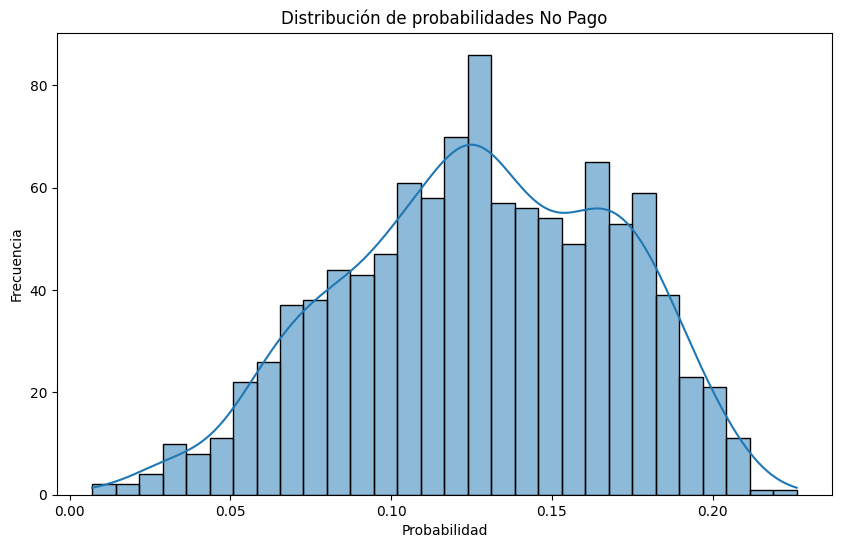

In [ ]:
# Cómo están distribuidas las probabilidades?
plt.figure(figsize=(10, 6))
sns.histplot(df_nuevos['probNoPago'], kde=True, bins=30)
plt.title('Distribución de probabilidades No Pago')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.show()

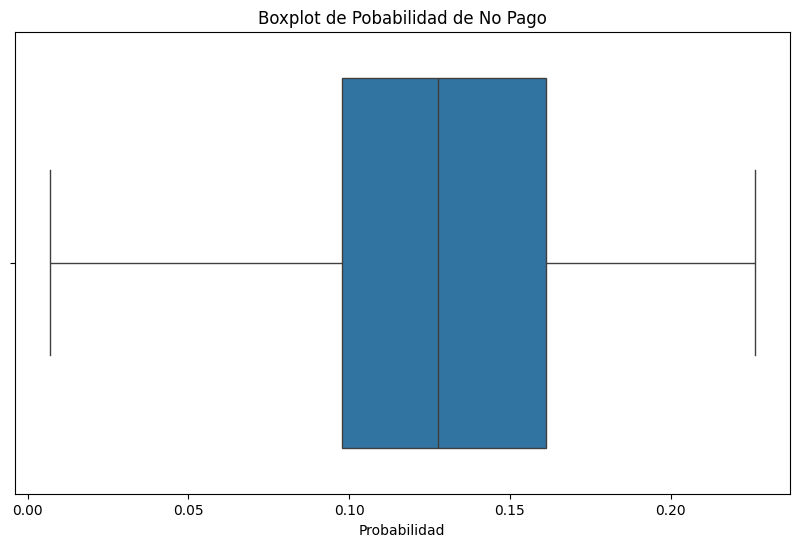

In [ ]:
# Boxplot para identificar si tenemos valores atipicos en int_rc
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_nuevos['probNoPago'])
plt.title('Boxplot de Pobabilidad de No Pago')
plt.xlabel('Probabilidad')
plt.show()

In [11]:
# Identificar valores atípicos
Q1 = df_nuevos['probNoPago'].quantile(0.25)
Q3 = df_nuevos['probNoPago'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_nuevos[(df_nuevos['probNoPago'] < lower_bound) | (df_nuevos['probNoPago'] > upper_bound)]
print(f"Número de valores atípicos: {len(outliers)}")

if len(outliers) >= 1:
    
    print("Valores atípicos:")
    print(outliers)

    outliers_stats = outliers['probNoPago'].describe()
    print("Estadísticas de los valores atípicos:")
    print(outliers_stats)


Número de valores atípicos: 0


In [12]:
# Retomamos los encoders para los datos históricos
# Convierte variables categóricas a numéricas
categorical_features = ['HomeOwnership', 'Education', 'MaritalStatus','RiesgoPagAtrazo']
label_encoders = {}

# Crear copias de los DataFrames originales
df_historico_mod = df_historico.copy()

for feature in categorical_features:
    le = LabelEncoder()
    df_historico_mod[feature] = le.fit_transform(df_historico_mod[feature])
    label_encoders[feature] = le

In [13]:
# Seleccion de las variables relevantes
features = ['CreditScore', 'DebtRatio', 'Assets', 'Age', 'NumberOfDependents',
            'NumberOfOpenCreditLinesAndLoans', 'MonthlyIncome', 'NumberOfTimesPastDue',
            'EmploymentLength', 'HomeOwnership', 'Education', 'MaritalStatus',
            'YearsAtCurrentAddress','RiesgoPagAtrazo']
target = 'NoPaidPerc'

In [14]:
X_historico = df_historico_mod[features]
y_historico = df_historico_mod[target]

In [15]:
# Escala las variables numéricas
scaler = StandardScaler()
X_historico = scaler.fit_transform(X_historico)

In [16]:
# Partimos los datos nuevamente en train y test
X_train, X_test, y_train, y_test = train_test_split(X_historico, y_historico, test_size=0.2, random_state=42)

In [17]:
# Aplicamos gradient boosting en los datos históricos
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [18]:
# y hacemos las predicciones nuevamente para anlizar el error
y_pred_test = best_model.predict(X_test)

# Calculamos la predicción del error
errors = y_test - y_pred_test

# y se ingresa en un dataframe
df_errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': errors
})

In [19]:
# Resumen de las estadisticas de los errores
error_summary = df_errors['Error'].describe()
print(error_summary)


count    2000.000000
mean        0.000886
std         0.034392
min        -0.200042
25%        -0.010712
50%         0.004930
75%         0.019845
max         0.093131
Name: Error, dtype: float64


# Analisis
### Media del error (mean): Valor 0.000886
Esto indica que, en promedio, las predicciones del modelo tienen un error muy cercano a 0, lo cual sugiere que el modelo no tiene un sesgo significativo hacia sobrestimar o subestimar las tasas de interés.

### Desviación estándar (std): Valor 0.034392
La desviación estándar representa la dispersión de los errores en torno a la media. Un valor bajo sugiere que la mayoría de los errores están cercanos al promedio, lo cual es un buen indicador de estabilidad y precisión del modelo.

## Errores mínimo (min) y máximo (max):
Mínimo: -0.200042
Máximo: 0.093131
El error mínimo negativo (-0.200042) indica que el modelo subestimó en un 20% en el peor caso. Por otro lado, el error máximo positivo (0.093131) muestra que el modelo sobreestimó en un 9.3% en el peor caso.
Interpretación: El modelo es más propenso a subestimar valores extremos, lo cual puede ser relevante dependiendo del impacto de estos casos en las decisiones de negocio.

## Percentiles (25%, 50%, 75%):
25% (Q1): -0.010712 → El 25% de los errores está por debajo de -1.07%.
50% (mediana): 0.004930 → La mitad de los errores está por debajo de 0.49%, mostrando que el modelo predice con bastante precisión en la mayoría de los casos.
75% (Q3): 0.019845 → El 75% de los errores está por debajo de 1.98%, lo que indica que los errores extremos son poco frecuentes

## Asimetría en los errores:
La media y la mediana están muy cerca de 0, lo que indica que los errores están distribuidos de manera simétrica alrededor del 0. Esto sugiere que el modelo no tiene un sesgo fuerte en sus predicciones.

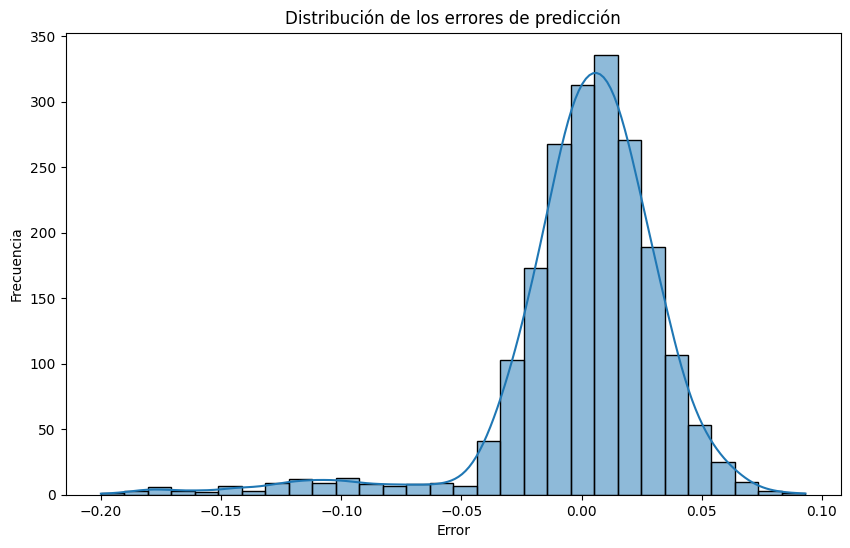

In [ ]:
# Distribución de los errores
plt.figure(figsize=(10, 6))
sns.histplot(df_errors['Error'], kde=True, bins=30)
plt.title('Distribución de los errores de predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

La distribución es simétrica y centrada cerca de 0, lo que indica que el modelo no tiene sesgos significativos.
La mayoría de los errores se encuentran en un rango cercano a ±0.05, lo que demuestra buena precisión en las predicciones.

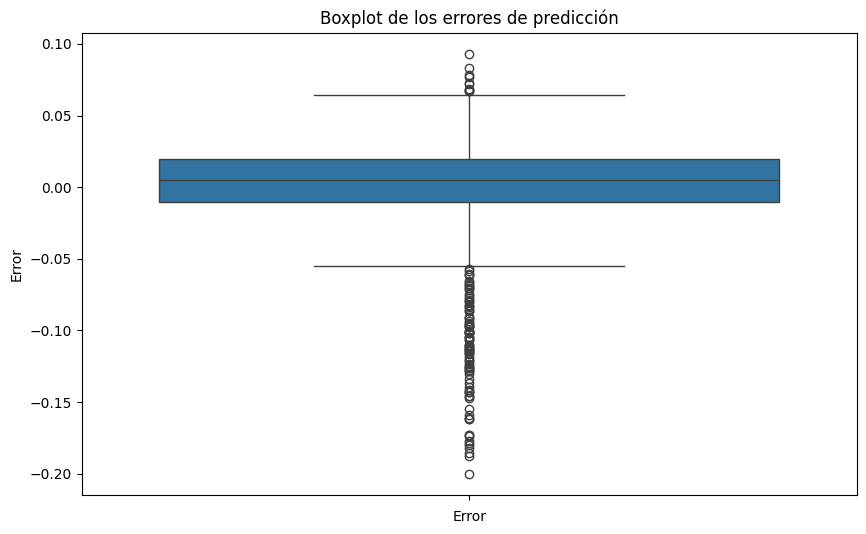

In [21]:
# Distribución delos atipicos
plt.figure(figsize=(10, 6))
sns.boxplot(df_errors['Error'])
plt.title('Boxplot de los errores de predicción')
plt.xlabel('Error')
plt.show()

La mediana está cerca de 0, confirmando que la mayoría de las predicciones tienen errores pequeños y balanceados.

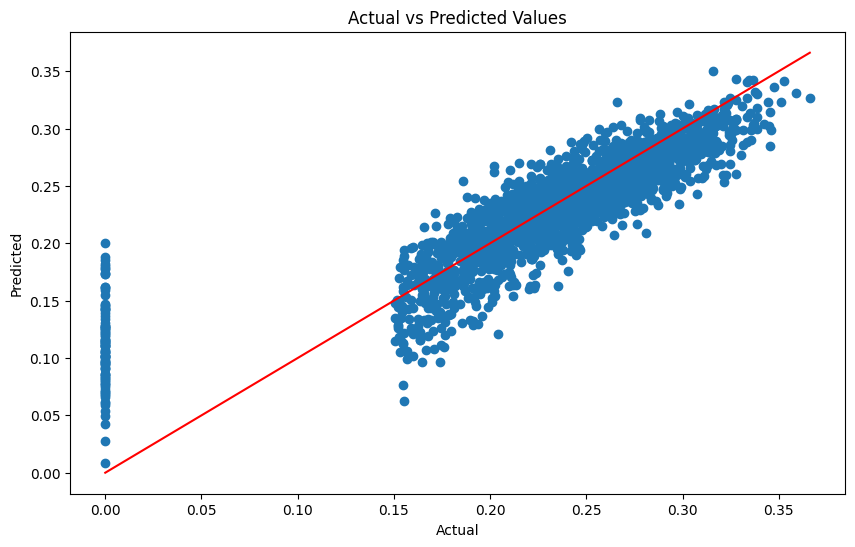

In [22]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df_errors['Actual'], df_errors['Predicted'])
plt.plot([min(df_errors['Actual']), max(df_errors['Actual'])], [min(df_errors['Actual']), max(df_errors['Actual'])], color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Los puntos siguen de cerca la línea roja (línea de ideal predicción), lo que demuestra que el modelo predice con gran precisión.
Los pocos puntos alejados de la línea indican ligeras desviaciones, pero no representan una tendencia sistemática.

In [23]:
# Métricas del error
mse = mean_squared_error(df_errors['Actual'], df_errors['Predicted'])
mae = mean_absolute_error(df_errors['Actual'], df_errors['Predicted'])
medae = median_absolute_error(df_errors['Actual'], df_errors['Predicted'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MedAE: {medae}')

MSE: 0.0011829874257131058
MAE: 0.022817871398401513
MedAE: 0.016348052738789726


MSE: La media cuadrática del error es baja, mostrando que el modelo maneja bien tanto errores pequeños como extremos.
MAE: La media absoluta del error es 0.0228, lo que indica que, en promedio, el modelo se desvía solo un 2.28% de los valores reales.
MedAE: Similar al MAE, la mediana del error absoluto muestra que la mayoría de las predicciones tienen errores bajos.